In [27]:
""" 
# 3-Class Driver Drowsiness Detection Model

Classes:
- 0 → ALERT
- 1 → DROWSY
- 2 → CRITICAL (Microsleep)

This notebook trains an LSTM model using EAR (Eye Aspect Ratio) sequences. 
"""

' \n# 3-Class Driver Drowsiness Detection Model\n\nClasses:\n- 0 → ALERT\n- 1 → DROWSY\n- 2 → CRITICAL (Microsleep)\n\nThis notebook trains an LSTM model using EAR (Eye Aspect Ratio) sequences. \n'

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [29]:
SEQUENCE_LENGTH = 20
SAMPLES_PER_CLASS = 3000
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


In [30]:
def generate_sequence(label):
    """
    label = 0 → ALERT
    label = 1 → DROWSY
    label = 2 → CRITICAL
    """

    if label == 0:  # ALERT (normal with blinks)
        base = np.random.uniform(0.28, 0.32)
        seq = []
        for _ in range(SEQUENCE_LENGTH):
            if np.random.rand() < 0.1:  # blink
                seq.append(np.random.uniform(0.18, 0.22))
            else:
                seq.append(base + np.random.normal(0, 0.01))

    elif label == 1:  # DROWSY (gradual fatigue)
        start = np.random.uniform(0.28, 0.30)
        end = np.random.uniform(0.20, 0.22)
        seq = np.linspace(start, end, SEQUENCE_LENGTH)
        seq += np.random.normal(0, 0.01, SEQUENCE_LENGTH)

    else:  # CRITICAL (microsleep)
        seq = np.random.uniform(0.12, 0.16, SEQUENCE_LENGTH)

    return np.clip(seq, 0.12, 0.35)


In [31]:
X, y = [], []

for label in [0, 1, 2]:
    for _ in range(SAMPLES_PER_CLASS):
        X.append(generate_sequence(label))
        y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (9000, 20)
y shape: (9000,)


In [32]:
X = X.reshape(-1, SEQUENCE_LENGTH, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)


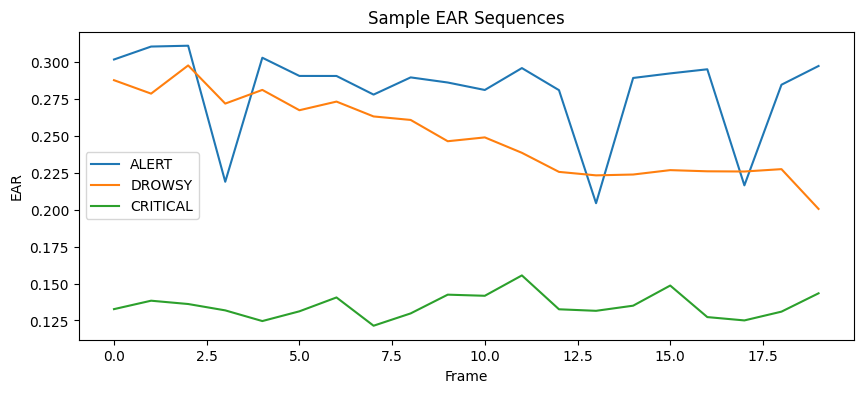

In [33]:
plt.figure(figsize=(10,4))

plt.plot(X[y == 0][0].flatten(), label="ALERT")
plt.plot(X[y == 1][0].flatten(), label="DROWSY")
plt.plot(X[y == 2][0].flatten(), label="CRITICAL")

plt.title("Sample EAR Sequences")
plt.xlabel("Frame")
plt.ylabel("EAR")
plt.legend()
plt.show()


In [34]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\ANUBHAV\OneDrive\Pictures\NoNap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,467 (119.01 KB)

 Trainable params: 30,467 (119.01 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            patience=4,
            restore_best_weights=True
        )
    ]
)


Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7839 - loss: 0.4469 - val_accuracy: 0.9450 - val_loss: 0.1355
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9624 - loss: 0.1085 - val_accuracy: 0.9756 - val_loss: 0.0892
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9833 - loss: 0.0501 - val_accuracy: 0.9839 - val_loss: 0.0488
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9804 - loss: 0.0553 - val_accuracy: 0.9944 - val_loss: 0.0195
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9911 - loss: 0.0293 - val_accuracy: 0.9933 - val_loss: 0.0179
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9871 - loss: 0.0372 - val_accuracy: 0.9972 - val_loss: 0.0337
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9925 - loss: 0.0239 - val_accuracy: 0.9878 - val_loss: 0.0354
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9922 - loss: 0.0253 - val_accu

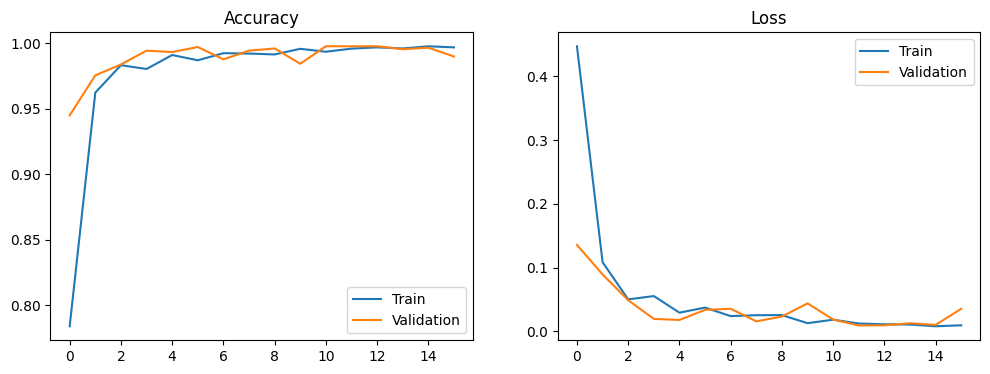

In [36]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


In [37]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       585
           1       1.00      1.00      1.00       601
           2       1.00      1.00      1.00       614

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

Confusion Matrix:
[[582   3   0]
 [  1 600   0]
 [  0   0 614]]


In [38]:
model.save("drowsiness_lstm_3class_tf.keras", save_format="keras")
print("Model saved")


Model saved
